# Baseline results: Normalizing Flow with Glow Blocks

As a baseline, we have a NF model without causal understanding. That is, we do not impose a prior distribution that adheres to the causal model implied by the latent causal graph. In addition, we do not maximize the likelihood across the different distributions, but treat the entire dataset as a single distribution.

In [1]:
import math
import os
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets.utils as dataset_utils
from PIL import Image
from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from gendis.datasets import CausalMNIST, ClusteredMultiDistrDataModule
from gendis.model import NeuralClusteredASCMFlow
from gendis.noncausal.flows import (
    CouplingLayer,
    Dequantization,
    GatedConvNet,
    Reshape,
    SplitFlow,
    SqueezeFlow,
    VariationalDequantization,
    create_channel_mask,
    create_checkerboard_mask,
)
from gendis.noncausal.model import ImageFlow
from gendis.variational.vae import VAE

/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/Users/adam2392/miniforge3/envs/cdrl/lib/python3.

In [2]:
def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = (
        imgs.dtype == torch.int32
        if isinstance(imgs, torch.Tensor)
        else imgs[0].dtype == torch.int32
    )
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs / nrow))
    imgs = torchvision.utils.make_grid(
        imgs, nrow=nrow, pad_value=128 if is_int else 0.5
    )
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5 * nrow, 1.5 * ncol))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

In [47]:
seed = 1
graph_type = "chain"
epoch = 2093
step = 43974
results_dir = Path(
    f"/Users/adam2392/pytorch_data/data/noncausalflow/nf-notransform-clipgrad-batch1024-{graph_type}-seed={seed}/"
)

seed = 2
epoch = 849
step = 17850
results_dir = Path(
    f"/Users/adam2392/pytorch_data/data/noncausalflow/nf-noquant-channelmasking-batch1024-{graph_type}-seed={seed}/"
)

# multi-scale
seed = 1
epoch = 2927
step = 245952
results_dir = Path(
    f"/Users/adam2392/pytorch_data/data/noncausalflow/nf-3point1M-batch256-{graph_type}-seed={seed}/"
)

# multi-scale w/ 256 batch size
seed = 2
epoch = 7603
step = 638736
results_dir = Path(
    f"/Users/adam2392/pytorch_data/data/noncausalflow/nf-3point1M-cosinelr-batch256-{graph_type}-seed={seed}/"
)

checkpoint_fname = results_dir / f"epoch={epoch}-step={step}.ckpt"
model = ImageFlow.load_from_checkpoint(checkpoint_fname)



Inside image flow...
torch.Size([16, 12, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 12, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 12, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 12, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 12, 7, 7])
Running:  <class 'gendis.noncausal.flows.SplitFlow'> torch.Size([16, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.SqueezeFlow'> torch.Size([16, 6, 14, 14])
Running:  <class 'gendis.noncausal.flows.SplitFlow'> torch.Size([16, 12, 14, 14])
Running:  <class 'gendis.noncausa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 3, 28, 28])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 3, 28, 28])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 3, 28, 28])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 3, 28, 28])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([16, 3, 28, 28])


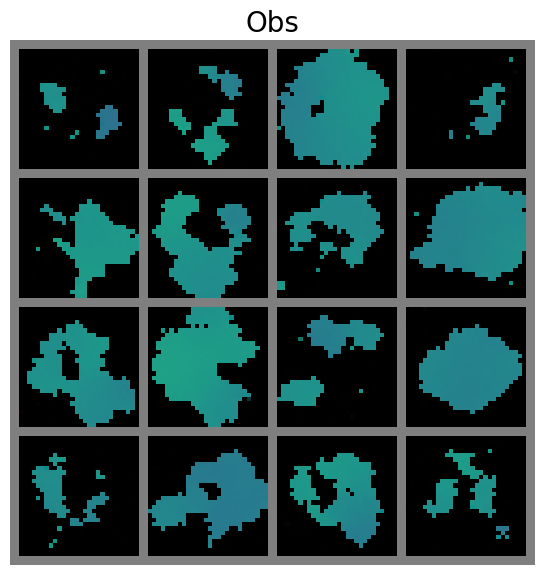

In [48]:
obs_imgs = model.sample(img_shape=[16, 12, 7, 7])
new_obs_imgs = torch.zeros_like(obs_imgs)
for idx, whole_image in enumerate(obs_imgs):
    for color_idx in range(3):
        # print(image.min(), image.max())
        image = whole_image[color_idx, ...]
        new_image = (image - image.min()) / (image.max() - image.min())
        new_obs_imgs[idx, color_idx, ...] = new_image
show_imgs(obs_imgs, title="Obs")

In [36]:
img_scale_shape = (5, 24, 7, 7)
prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
output = prior.sample(img_scale_shape)
ldj = torch.zeros(img_scale_shape[0])
for flow in reversed(model.flows):
    output, ldj = flow(output, ldj, reverse=True)
    print("Running: ", type(flow), output.shape)

Running:  <class 'gendis.noncausal.flows.Reshape'> torch.Size([5, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 24, 7, 7])
Running:  <class 'gendis.noncausal.flows.SqueezeFlow'> torch.Size([5, 6, 14, 14])
Running:  <class 'gendis.noncausal.flows.SplitFlow'> torch.Size([5, 12, 14, 14])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 12, 14, 14])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 12, 14, 14])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 12, 14, 14])
Running:  <class 'gendis.noncausal.flows.CouplingLayer'> torch.Size([5, 12, 14, 14])
Running:  <class 'gendis.noncausal.flows.SqueezeFlow'> torch.Size([5, 3, 28, 28])
Runnin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


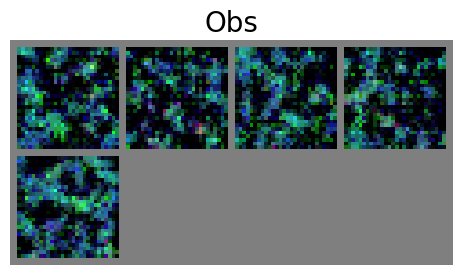

In [37]:
show_imgs(output, title="Obs")

<Axes: ylabel='Count'>

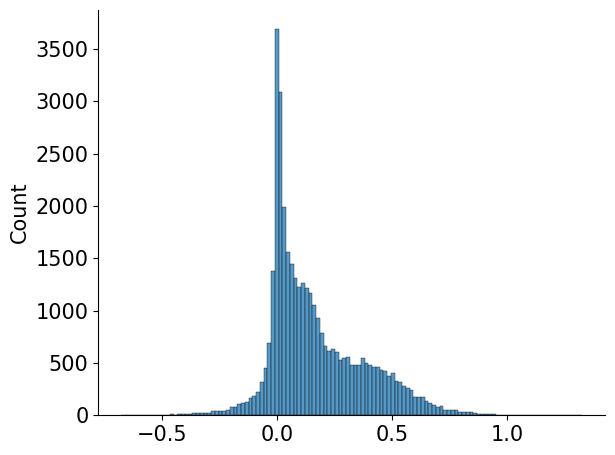

In [38]:
sns.histplot(obs_imgs.flatten())

In [5]:
print(24 * 7 * 7)

1176


In [6]:
print(784 * 3 // 2)

1176


# Test Multiscal flow

In [14]:
# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # nf.utils.Scale(255.0 / 256.0),  # normalize the pixel values
        nf.utils.Jitter(1 / 256.0),  # apply random generation
        # discretize,
    ]
)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(
    root="/Users/adam2392/pytorch_data/", train=True, transform=transform, download=True
)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

Global seed set to 42


In [26]:
class CouplingLayer(nn.Module):

    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter,
        # but should be part of the modules state.
        self.register_buffer("mask", mask)

    def forward(self, z, ldj, reverse=False, orig_img=None):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows.
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1, 2, 3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1, 2, 3])

        return z, ldj


def create_multiscale_flow():
    flow_layers = []

    vardeq_layers = [
        CouplingLayer(
            network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
            mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
            c_in=1,
        )
        for i in range(4)
    ]
    flow_layers += [VariationalDequantization(vardeq_layers)]

    flow_layers += [
        CouplingLayer(
            network=GatedConvNet(c_in=1, c_hidden=32),
            mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
            c_in=1,
        )
        for i in range(2)
    ]
    flow_layers += [SqueezeFlow()]
    for i in range(2):
        flow_layers += [
            CouplingLayer(
                network=GatedConvNet(c_in=4, c_hidden=48),
                mask=create_channel_mask(c_in=4, invert=(i % 2 == 1)),
                c_in=4,
            )
        ]
    flow_layers += [SplitFlow(), SqueezeFlow()]
    for i in range(4):
        flow_layers += [
            CouplingLayer(
                network=GatedConvNet(c_in=8, c_hidden=64),
                mask=create_channel_mask(c_in=8, invert=(i % 2 == 1)),
                c_in=8,
            )
        ]

    flow_model = ImageFlow(flow_layers)
    return flow_model

In [29]:
model = create_multiscale_flow()
model.sample((5, 24, 7, 7))



Inside image flow...
torch.Size([5, 24, 7, 7])


RuntimeError: The size of tensor a (24) must match the size of tensor b (8) at non-singleton dimension 1

In [23]:
img_scale_shape = (5, 24, 7, 7)
img = torch.cat((train_set[0][0], train_set[1][0]))
img = img.reshape(2, 1, 28, 28)
prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
# img = torch.randn((5, 1, 28, 28)).abs()
print(img.shape)

torch.Size([2, 1, 28, 28])


In [28]:
model.sample((5, 1, 28, 28))



Inside image flow...
torch.Size([5, 1, 28, 28])
Running:  <class '__main__.CouplingLayer'> torch.Size([5, 8, 28, 28])
Running:  <class '__main__.CouplingLayer'> torch.Size([5, 8, 28, 28])
Running:  <class '__main__.CouplingLayer'> torch.Size([5, 8, 28, 28])
Running:  <class '__main__.CouplingLayer'> torch.Size([5, 8, 28, 28])
Running:  <class 'gendis.noncausal.flows.SqueezeFlow'> torch.Size([5, 2, 56, 56])
Running:  <class 'gendis.noncausal.flows.SplitFlow'> torch.Size([5, 4, 56, 56])
Running:  <class '__main__.CouplingLayer'> torch.Size([5, 4, 56, 56])
Running:  <class '__main__.CouplingLayer'> torch.Size([5, 4, 56, 56])
Running:  <class 'gendis.noncausal.flows.SqueezeFlow'> torch.Size([5, 1, 112, 112])


RuntimeError: The size of tensor a (112) must match the size of tensor b (28) at non-singleton dimension 3

In [24]:
output, ldj = model(img)

RuntimeError: The size of tensor a (2) must match the size of tensor b (7) at non-singleton dimension 2